In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from jax import numpy as jnp
import optax
from scipy.integrate import trapezoid

# np.set_printoptions(precision=15)  # For consistent display precision

import warnings
warnings.filterwarnings("ignore")

### Gaussian Distribution

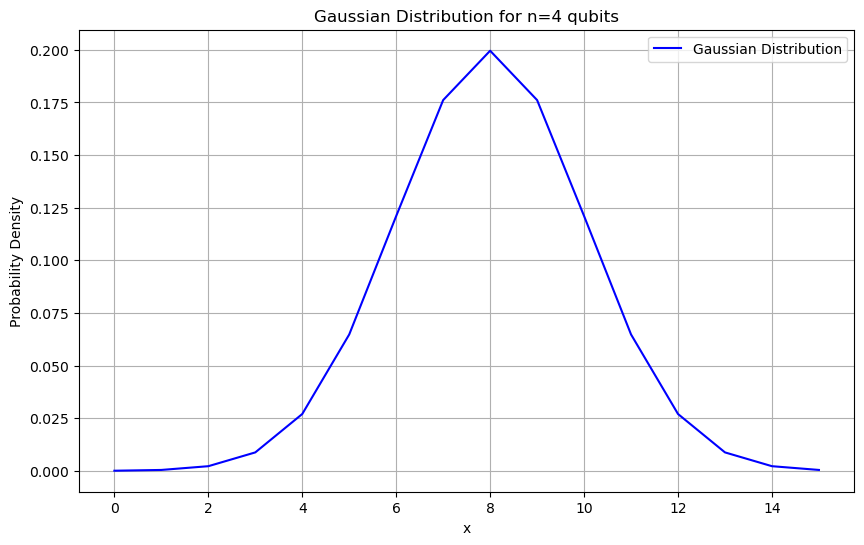

In [2]:
n_qubits = 4
# x values for 6 qubits range from 0 to 16
x = np.arange(0, 2**n_qubits, dtype=np.float64)

# Parameters for the Gaussian distribution
mu = 2**(n_qubits-1)  # mean
sigma = 2**(n_qubits-1)/4  # standard deviation

# Gaussian distribution formula
gaussian_distribution = (1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2))

area = trapezoid(gaussian_distribution,x)
gaussian_distribution /= area

# Plot the Gaussian distribution
plt.figure(figsize=(10, 6))
plt.plot(x, gaussian_distribution, label='Gaussian Distribution', color='blue')
plt.title(f'Gaussian Distribution for n={n_qubits} qubits')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

### Particle Number Distibution

In [3]:
def pnumber_distribution(distribution):
    p_distribution = np.zeros(n_qubits+1,dtype=np.float64)
    
    for i in range(2**n_qubits):
        binary_string = format(i,'06b')
        num_of_ones = binary_string.count('1')
        p_distribution[num_of_ones] += distribution[i]
        
    #Normalize the distribution
    p_distribution/=p_distribution.sum()
    return p_distribution

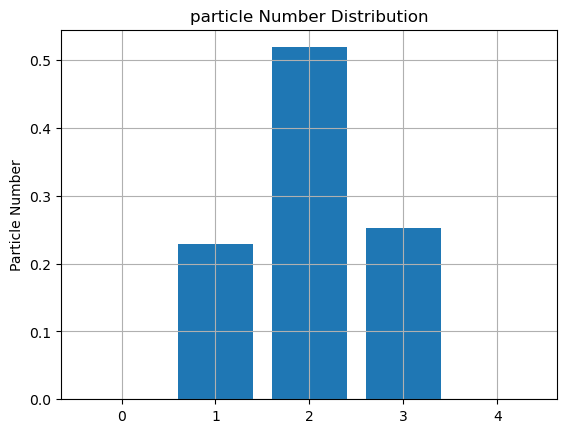

In [4]:
targetp_distribution = pnumber_distribution(gaussian_distribution)
plt.bar(range(n_qubits+1), targetp_distribution)
plt.title('particle Number Distribution')
plt.ylabel('Particle Number')
plt.xticks(range(n_qubits+1))
plt.grid(True)
plt.show()

### QCBM Circuit

In [23]:
from scipy.special import comb


dev = qml.device('default.qubit',wires=n_qubits)

def random_init(num_qubits,distribution=targetp_distribution):
    all_states = []
    for i in range(2**num_qubits):
        binary_string = format(i,'04b')
        all_states.append(binary_string)
    # all_state_dict = {i:0 for i in all_states}

    # a=np.random.choice(['0001','0010','0100','1000'],1)[0]
    # b=np.random.choice(['0011','0101','1001','0110','1100','1010'],1)[0]
    # c=np.random.choice(['0111','1011','1101','1110'],1)[0]
    
    # chosen_states = ['0000','0001','0011','0111','1111']
    # chosen_state_dict = dict(zip(chosen_states,np.sqrt(distribution)))
    amps = []
    
    #uniform distribution of all possible states
    for i in all_states:
        num_of_ones = i.count('1')
        number_of_states_with_num_of_ones = comb(num_qubits, num_of_ones)
        amps.append(distribution[num_of_ones] / number_of_states_with_num_of_ones)
        
    amps = np.sqrt(amps)       
    # all_state_dict.update(chosen_state_dict)
    
    
    #amplitudes
    # amps = list(all_state_dict.values())
    # norm = np.sqrt(sum(np.abs(amp)**2 for amp in amps))
    # amps = amps/norm
    
    #print(amps)
    qml.StatePrep(amps,wires=range(num_qubits))
    
def qcbm_circuit(params,num_qubits):
    
    rz_params = params[:num_qubits]
    ising_params = params[num_qubits:]
    
    for i in range(num_qubits):
        # qml.RX(ising_params[i],wires=i)
        qml.RZ(rz_params[i],wires=i)

    # qml.CNOT(wires=[0,1])
    # qml.CNOT(wires=[1,2])
    # qml.CNOT(wires=[2,3])
    # qml.CNOT(wires=[3,0])
    qml.IsingXY(ising_params[0],wires=[0,1])
    qml.IsingXY(ising_params[2],wires=[1,2])
    qml.IsingXY(ising_params[1],wires=[2,3])
    qml.IsingXY(ising_params[3],wires=[3,0])
    
    qml.IsingZZ(ising_params[0],wires=[0,1])
    qml.IsingZZ(ising_params[2],wires=[1,2])
    qml.IsingZZ(ising_params[1],wires=[2,3])
    qml.IsingZZ(ising_params[3],wires=[3,0])
    


@qml.qnode(dev)
def circuit(input_params,distibution=targetp_distribution,num_qubits=n_qubits):
    
    #Random state for pretraining
    random_init(num_qubits,distibution)
    
    #Layers of Rotation + Entangling gates
    for i in range(2):
        qml.Barrier(range(num_qubits))
        qcbm_circuit(params=input_params[i],num_qubits=num_qubits)
    return qml.probs()


### Loss Function

In [24]:
class MMD:
    def __init__(self,scales,space):
        gammas = 1/(2*(scales**2)).reshape(-1,1,1)
        sq_dists = np.abs(space[:,None] - space[None,:])**2
        self.K = np.sum(np.exp(-gammas * sq_dists), axis=0)/len(scales)
        self.scales = scales
        
    def k_expval(self,px,py):
        return px @ self.K @ py
    
    def __call__(self,px,py):
        pxy = px-py
        return self.k_expval(pxy,pxy)
    
class QCBM:
    def __init__(self,circ,mmd,py):
        self.circ = circ
        self.mmd = mmd
        self.py = py
    
    def mmd_loss(self,params):
        px = self.circ(params)
        return self.mmd(px,self.py), px

In [25]:
folds = 2
initial_params = []
for i in range(folds):
    #Each layer has 2*4=8 params i.e., 4 Rotation + 4 Entangling
    initial_params.append(np.random.rand(3*n_qubits).tolist())

### Training the Model

In [26]:
def update_step(params,opt_state):
    
    (loss_val,qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss,has_aux=True)(params)
    
    updates,opt_state = opt.update(grads,opt_state)
    params = optax.apply_updates(params,updates)
    
    qcbm_probs = jnp.asarray(qcbm_probs, dtype=jnp.float64)
    
    kl_div = -np.sum(gaussian_distribution * np.nan_to_num(np.log(qcbm_probs) - np.log(gaussian_distribution)))
    
    return params, opt_state, loss_val, kl_div

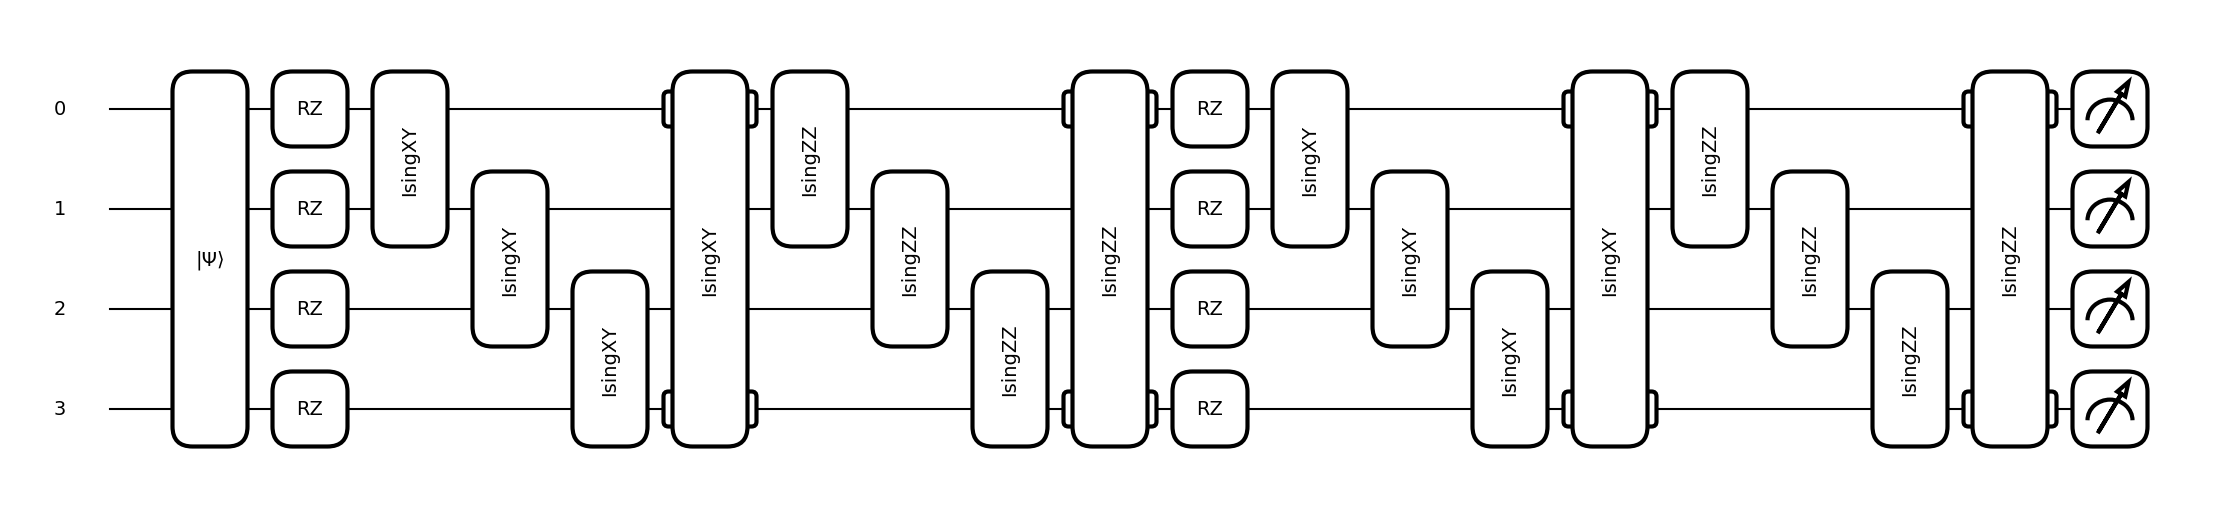

In [27]:
qml.draw_mpl(circuit,level='device')(input_params=initial_params)
plt.show()

In [28]:
#Calling MMD class
bandwidth = np.array([0.25,60],dtype=np.float64)
space = np.arange(0,2**n_qubits,dtype=np.float64)
mmd = MMD(bandwidth,space=space)

#Calling QCBM class to run the previous built circuit with random weights
qcbm = QCBM(circuit,mmd=mmd,py=gaussian_distribution)

#Call an optimizer
opt = optax.adam(learning_rate=1)
opt_state = opt.init(initial_params)

history = []
divs = []
parameters = []
n_iterations = 200

weights = initial_params

for i in range(n_iterations+1):
    weights, opt_state, loss_val, kl_div = update_step(params=weights,opt_state=opt_state)
    
    if i%10==0:
        print(f"Step: {i} Loss: {loss_val} KL_div:{kl_div}")
        #print(f"Params: {weights}")
    
    history.append(loss_val)
    divs.append(kl_div)
    parameters.append(weights)

Step: 0 Loss: 0.06838271021842957 KL_div:1.503498937339172
Step: 10 Loss: 0.027132434770464897 KL_div:0.4617786935070961
Step: 20 Loss: 0.011564381420612335 KL_div:0.1749408914567602
Step: 30 Loss: 0.003351009450852871 KL_div:0.09652689254987837
Step: 40 Loss: 0.001066597644239664 KL_div:0.04008737024503126
Step: 50 Loss: 0.0003821497957687825 KL_div:0.018387271010521997
Step: 60 Loss: 0.0001535741175757721 KL_div:0.006059562607351143
Step: 70 Loss: 3.46177548635751e-05 KL_div:0.006147420743368944
Step: 80 Loss: 1.3260598279885016e-05 KL_div:0.0018216426599854882
Step: 90 Loss: 6.1790547078999225e-06 KL_div:0.0008324717483204694
Step: 100 Loss: 1.614416646589234e-06 KL_div:0.0006137001096687526
Step: 110 Loss: 9.984648841054877e-07 KL_div:0.0004295015496996007
Step: 120 Loss: 2.7530168722478265e-07 KL_div:0.00029718345554709166
Step: 130 Loss: 1.3089149319966964e-07 KL_div:0.0002875970246637766
Step: 140 Loss: 7.289916226227433e-08 KL_div:0.00026529184915694584
Step: 150 Loss: 5.007530

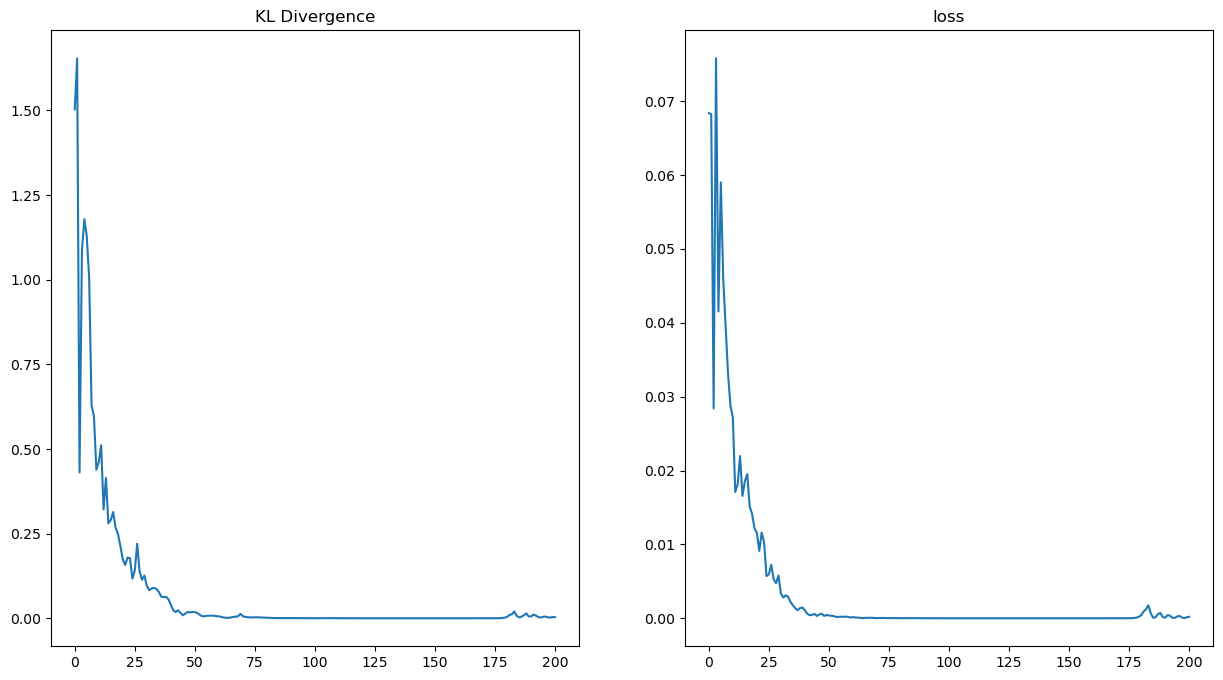

In [29]:
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].plot(divs)
axs[0].title.set_text('KL Divergence')

axs[1].plot(history)
axs[1].title.set_text('loss')


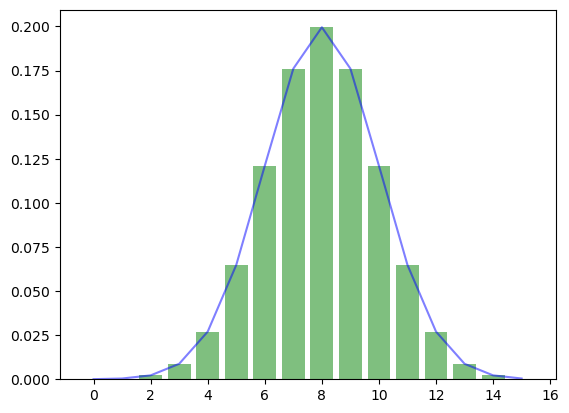

In [30]:
optimal_params = parameters[np.argmin(history)]
qcbm_probs = circuit(optimal_params)
plt.bar(x,qcbm_probs,color='green',alpha=0.5,label='obtained_distribution')
plt.plot(x,gaussian_distribution,color='blue',alpha=0.5,label='target_distribution')

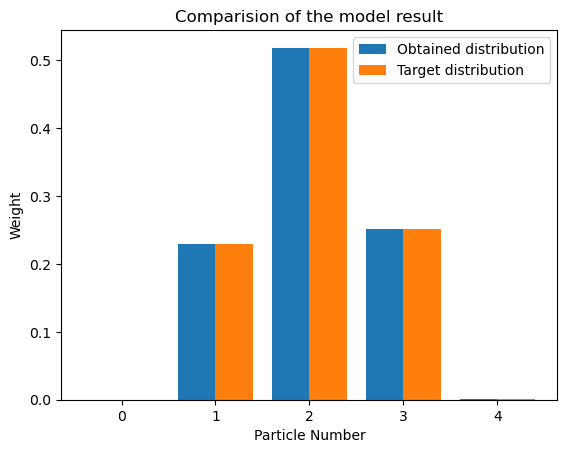

In [31]:
x_axis = np.arange(n_qubits+1)
obtained_pdistribution = pnumber_distribution(qcbm_probs)
plt.bar(x_axis-0.2,obtained_pdistribution,width=0.4,label='Obtained distribution')
plt.bar(x_axis+0.2,targetp_distribution,width=0.4,label='Target distribution')

plt.xticks(x_axis,range(n_qubits+1))
plt.xlabel('Particle Number')
plt.ylabel('Weight')
plt.title('Comparision of the model result')
plt.legend()
plt.show()

In [32]:
np.sum(gaussian_distribution * ((np.log(qcbm_probs) - np.log(gaussian_distribution))))

-0.00025746922327416193

In [33]:
np.sum(gaussian_distribution * np.nan_to_num(np.log(qcbm_probs/gaussian_distribution)))

-0.0002574628994079163

In [37]:
qcbm_probs.tolist()

[6.69207438477315e-05,
 0.0003767601156141609,
 0.0022373676765710115,
 0.008751200512051582,
 0.02701812982559204,
 0.06471069157123566,
 0.12094005942344666,
 0.1760990470647812,
 0.19950592517852783,
 0.1760556995868683,
 0.1210852786898613,
 0.06475554406642914,
 0.027022643014788628,
 0.008782798424363136,
 0.002155385445803404,
 0.00043637806084007025]